# Project Showcase : Twitter Depression Detection 🙂🕵️‍♀️
I have taken an already collected and combined dataset from [swcwang/depression-detector](https://github.com/swcwang/depression-detection) since they were kind enough to open source a dataset for depression detection that they built and combined to get optimal results with their models

> you can look over their Data Collection model [here](https://github.com/swcwang/depression-detection#collecting-data)

I have already implemented this project with preprocessing using torchtext and using an adaptive GRU model with concat pooling achieving an accuracy of 78%

In this I will be implementing the LSTM-CNN approach 

# 📦 LSTM-CNN for our models

The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:

- **Activity Recognition**: Generating a textual description of an activity demonstrated in a sequence of images.
- **Image Description**: Generating a textual description of a single image.
- **Video Description**: Generating a textual description of a sequence of images.

This architecture has also been used on speech recognition and natural language processing problems where CNNs are used as feature extractors for the LSTMs on audio and textual input data.

This architecture is appropriate for problems that:

- Have spatial structure in their input such as the 2D structure or pixels in an image or the 1D structure of words in a sentence, paragraph, or document.
- Have a temporal structure in their input such as the order of images in a video or words in text, or require the generation of output with temporal structure such as words in a textual description.
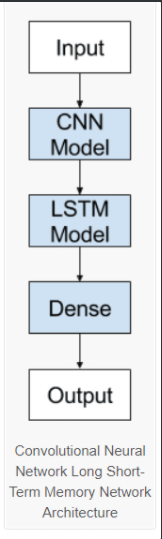

### ⇒ **Implement CNN LSTM in Keras**

We can define a CNN LSTM model to be trained jointly in Keras.

A CNN LSTM can be defined by adding CNN layers on the front end followed by LSTM layers with a Dense layer on the output.

It is helpful to think of this architecture as defining two sub-models: the CNN Model for feature extraction and the LSTM Model for interpreting the features across time steps.

In [36]:
# Importing our libraries

import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from textblob import TextBlob
from math import log, sqrt, exp
import pandas as pd
import numpy as np
from numpy import sign

import re
import warnings
warnings.filterwarnings("ignore")
import ftfy
#from bs4 import BeautifulSoup

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import ftfy

import pandas as pd
import matplotlib as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
import ftfy
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Raze\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pip install ftfy

In [3]:
np.random.seed(1234)

DEPRES_NROWS = 15000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 10000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 280 # Max tweet size
MAX_NB_WORDS = 6250
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2
LEARNING_RATE = 0.5
EPOCHS= 20

In [4]:
df2 = pd.read_csv("tweets_combined.csv")
df2.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty &amp; laughs Kung Fu...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0


In [5]:
emojies = [":‑)", ":)", ":D", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)", "=)", ":}", ":^)", ":っ)", ":‑D", "8‑D", "8D", "x‑D", "xD", "X‑D", "XD", "=‑D", "=D", "=‑3", "=3", "B^D", ":-))", ">:[", ":‑(", ":(", ":‑c", ":c", ":‑<", ":っC", ":<", ":‑[", ":[", ":{", ";(", ":-||", ":@", ">:(", ":'‑(", ":'(", ":'‑)", ":')", "D:<", "D:", "D8", "D;", "D=", "DX", "v.v", "D‑':", ">:O", ":‑O", ":O", ":‑o", ":o", "8‑0", "O_O", "o‑o", "O_o", "o_O", "o_o", "O-O", ":*", ":-*", ":^*", "(", "}{'", ")", ";‑)", ";)", "*-)", "*)", ";‑]", ";]", ";D", ";^)", ":‑,", ">:P", ":‑P", ":P", "X‑P", "x‑p", "xp", "XP", ":‑p", ":p", "=p", ":‑Þ", ":Þ", ":þ", ":‑þ", ":‑b", ":b", "d:", ">:\\", ">:/", ":‑/", ":‑.", ":/", ":\\", "=/", "=\\", ":L", "=L", ":S", ">.<", ":|", ":‑|", ":$", ":‑X", ":X", ":‑#", ":#", "O:‑)", "0:‑3", "0:3", "0:‑)", "0:)", "0;^)", ">:)", ">;)", ">:‑)", "}:‑)", "}:)", "3:‑)", "3:)", "o/\o", "^5", ">_>^", "^<_<", "|;‑)", "|‑O", ":‑J", ":‑&", ":&", "#‑)", "%‑)", "%)", ":‑###..", ":###..", "<:‑|", "<*)))‑{", "><(((*>", "><>", "\o/", "*\0/*", "@}‑;‑'‑‑‑", "@>‑‑>‑‑", "~(_8^(I)", "5:‑)", "~:‑\\", "//0‑0\\\\", "*<|:‑)", "=:o]", "7:^]", ",:‑)", "</3", "<3"]

In [6]:
# Expand Contraction
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [7]:
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [8]:
import nltk
nltk.download('stopwords')
def clean_tweets(tweets):
    cleaned_tweets = []
    for tweet in tweets:
        tweet = str(tweet)
        # if url links, then don't append to avoid news articles, etc.
        # Check tweet length, save those > 6 (length of word "lonely")
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            tweet = re.sub(r"http\S+", "", tweet)
            tweet = re.sub(r'www.+', "", tweet)
            #remove hashtags, @mention, emoji and image URLs
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            # Remove HTML special entities (e.g. &amp;)
            tweet = re.sub(r'\&\w*;', '', tweet)
            #Convert @username to AT_USER
            tweet = re.sub('@[^\s]+','',tweet)
            # Remove tickers
            tweet = re.sub(r'\$\w*', '', tweet)
            # To lowercase
            tweet = tweet.lower()
            # Remove hyperlinks
            tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
            # Remove hashtags
            #tweet = re.sub(r'#\w*', '', tweet)
            # Remove Punctuation and split 's, 't, 've with a space for filter
            #tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
            # Remove words with 2 or fewer letters
            tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
            # Remove whitespace (including new line characters)
            tweet = re.sub(r'\s\s+', ' ', tweet)
            # Remove single space remaining at the front of the tweet.
            tweet = tweet.lstrip(' ') 
            # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
            tweet = ''.join(c for c in tweet if c <= '\uFFFF')
            #fix weirdly encoded texts
            tweet = ftfy.fix_text(tweet)
            #expand contraction
            tweet = expandContractions(tweet)
            #remove punctuation
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
            
            neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], tweet)
            letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
            
            # Tokenize and join to remove unneccessary white spaces
            words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
            #return (" ".join(words)).strip()

            #stop words
            stop_words = set(stopwords.words('english'))
            stop_words.update(("mon","tue","wed","thu","fri","sat","sun","sunday","monday","tuesday","thursday","friday","saturday","sunday","thurs","thur","tues"))
            stop_words.update(("january","february","march","april","may","june","july","august",
              "september","october","november","december","jan","feb","mar","apr",
              "may","jun","jul","aug","sep","oct","nov","dec", "twitter", "thanking","thanks"))
    
            word_tokens = nltk.word_tokenize(tweet) 
            filtered_sentence = [w for w in word_tokens if not w in stop_words]
            tweet = ' '.join(filtered_sentence)

            #stemming words
            tweet = PorterStemmer().stem(tweet)
            
            cleaned_tweets.append(tweet)

    return cleaned_tweets

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raze\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
#Applying the preprocessing clean_text function to every element in the depressive tweets and random tweets data.
tweets_arr = [x for x in df2['tweet']]
X_d = clean_tweets(tweets_arr)

In [10]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_d)

In [11]:
#Applying the tokenizer to depressive tweets and random tweets data.
sequences_d = tokenizer.texts_to_sequences(X_d)


In [12]:
#Number of unique words in tokenizer.
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 6389 unique tokens


In [13]:
#Pad sequences to the same length.
data_d = pad_sequences(sequences_d, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data_d tensor:', data_d.shape)

Shape of data_d tensor: (3197, 280)


# Word2Vec and Embedding
The embedding matrix is an n x m matrix where *n* is the number of words and *m* is the dimension of the embedding. 
We take the minimum between the number of unique words in our tokenizer and max words (in case there are fewer unique words than the max we specified).

In [14]:
EMBEDDING_FILE = 'GoogleNewsvectorsnegative300.bin'

In [15]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

2021-06-25 09:31:33,618 : INFO : loading projection weights from GoogleNewsvectorsnegative300.bin
2021-06-25 09:32:13,064 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from GoogleNewsvectorsnegative300.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-06-25T09:32:13.047871', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'load_word2vec_format'}


In [16]:
#The embedding matrix
nb_words = min(MAX_NB_WORDS, len(word_index))
# print(nb_words)
# print(word_index.items())
# print(word2vec.word_vec(word))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for (word, idx) in word_index.items():
    if word in word2vec.key_to_index and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)


# Splitting and Labelling the data

In [18]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = np.array([1] * DEPRES_NROWS)

# Splitting the arrays into training (60%), validation (20%), and testing data (20%)
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = data_d[idx_train_d]
labels_train = labels_d[idx_train_d]
data_test = data_d[idx_test_d]
labels_test = labels_d[idx_test_d]
data_val = data_d[idx_val_d]
labels_val = labels_d[idx_val_d]

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val = labels_val[perm_val]

## Building the LSTM-CNN model
The model takes in an input and then outputs a single number representing the probability that the tweet indicates depression. The model takes in each input sentence, replace it with its embeddings, and then runs the new embedding vector through a convolutional layer. CNNs are well suited for learning spatial structure from data. The convolutional layer takes advantage of this and learns structure from the sequential data which it passes into a standard LSTM layer. The output of the LSTM layer is fed into a Dense model for prediction.


In [20]:
model = Sequential()
# Embedded layer
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# Convolutional Layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
# LSTM Layer
model.add(LSTM(300))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

nadam = optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)


In [21]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer=nadam, metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 280, 300)          1875000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 140, 32)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 140, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               399600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [43]:
# #Training the model
# #The model is trained and Early Stopping is used to end training if the loss and/or accuracy don't improve within 3 epochs.
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

# hist = model.fit(data_train, labels_train, \
#         validation_data=(data_val, labels_val), \
#         epochs=EPOCHS, batch_size=16, shuffle=True, \
#         callbacks=[early_stop])

In [44]:
best_valid_loss = float('inf')

epochs=10

for epoch in range(epochs):      

    start_time = time.time()
    
    train_loss, train_acc = train(m, iter(data_train), opt, loss_fn, len(data_train))
    valid_loss, valid_acc = evaluate(m, iter(data_val), loss_fn, len(data_val))

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(m.state_dict(), 'tut4-model.pt')
          
        
    print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valid_loss:.4f} val_acc: {valid_acc:.4f}')


NameError: name 'train' is not defined

In [38]:
import matplotlib.pyplot as plt

KeyError: 'val_acc'

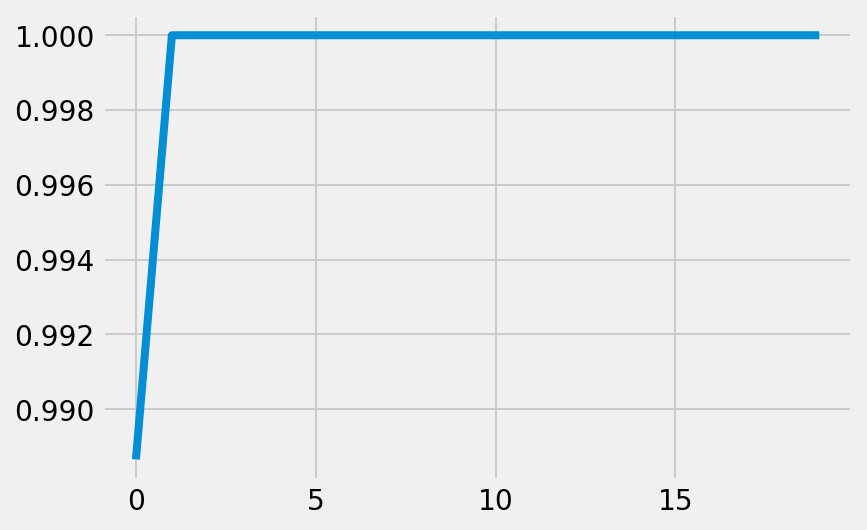

In [40]:
#Results: summarize the history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim(.92,1)
plt.show()

In [37]:
#Summarize for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0,.2))
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


AttributeError: module 'matplotlib' has no attribute 'plot'

In [24]:
#Percentage accuracy of model
labels_pred = model.predict(data_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 100.00%


In [25]:
#f1, precision, and recall scores
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       640

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640



In [26]:
print('\n# Evaluate')
model.evaluate(data_test, labels_test)


# Evaluate
20/20 [==============================] - 5s 160ms/step - loss: 3.3916e-07 - acc: 1.0000


[3.391646714590024e-07, 1.0]

In [27]:
score = model.evaluate(data_test, labels_test, verbose=0)

In [31]:
#https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
'''
import h5py


#model.save('detector_model_finalX.pt')
#model.save('detector_model_finalX.h5')

save_model(
    model,
    "keras.h5",
    overwrite=True,
    include_optimizer=True
)

json_string = model.to_json()
yaml_string = model.to_yaml()
#convert to json in terminal
#tensorflowjs_converter --input_format keras keras.h5 tensorflowjs/
'''

'\nimport h5py\n\n\n#model.save(\'detector_model_finalX.pt\')\n#model.save(\'detector_model_finalX.h5\')\n\nsave_model(\n    model,\n    "keras.h5",\n    overwrite=True,\n    include_optimizer=True\n)\n\njson_string = model.to_json()\nyaml_string = model.to_yaml()\n#convert to json in terminal\n#tensorflowjs_converter --input_format keras keras.h5 tensorflowjs/\n'

In [32]:
#Run the code below to save model to json and serialize the weights to HDF5
'''
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights.h5")
print("Saved model")
'''

'\nmodel_json = model.to_json()\nwith open("model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("model_weights.h5")\nprint("Saved model")\n'

In [34]:
# Run the code below to create pickle
'''
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
'''

"\nimport pickle\n\n# saving\nwith open('tokenizer.pickle', 'wb') as handle:\n    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\n# loading\nwith open('tokenizer.pickle', 'rb') as handle:\n    tokenizer = pickle.load(handle)\n    \n"

Comparing the Model to Benchmark